# Seismic Wave Tomography via Fast Marching - Reduced Likelihood

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/fmm_tomography/fmm_tomography_rl.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally) to set up the environment.

This notebook demonstrates the use of **Reduced Likelihood** methods for seismic tomography using the `ReducedLikelihood` and `ReducedLikelihoodManager` classes from `cofi.utils`.

We explore two cases:
1. **Scaled covariance**: $C_d = \nu \cdot C_d^{\text{ref}}$ where $\nu$ is estimated
2. **Spherical covariance**: $C_d = \sigma^2 I$ where $\sigma^2$ is estimated

## 0. Import modules

In [164]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso pyfm2d
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/fmm_tomography

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

import cofi
import espresso
import pyfm2d as wt
from cofi.utils import ReducedLikelihood, ReducedLikelihoodManager

## Theoretical background

In [166]:
# display theory on travel time tomography
from IPython.display import display, Markdown

with open("../../theory/geo_travel_time_tomography.md", "r") as f:
    content = f.read()

display(Markdown(content))

The goal in travel-time tomography is to infer details about the velocity structure of a medium, given measurements of the minimum time taken for a wave to propagate from source to receiver. For seismic travel times, as we change our model, the route of the fastest path from source to receiver also changes. This makes the problem nonlinear, as raypaths also depend on the sought after velocity or slowness model. 

Provided the 'true' velocity structure is not *too* dissimilar from our initial guess, travel-time tomography can be treated as a weakly non-linear problem. In this notebook we optionally treat the ray paths as fixed, and so it becomes a linear problem, or calculate rays in the velociuty model.

The travel-time of an individual ray can be computed as $$t = \int_\mathrm{path} \frac{1}{v(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$
This points to an additional complication: even for a fixed path, the relationship between velocities and observations is not linear. However, if we define the 'slowness' to be the inverse of velocity, $s(\mathbf{x}) = v^{-1}(\mathbf{x})$, we can write
$$t = \int_\mathrm{path} {s(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$
which *is* linear.


We will assume that the object we are interested in is 2-dimensional slowness field. If we discretize this model, with $N_x$ cells in the $x$-direction and $N_y$ cells in the $y$-direction, we can express $s(\mathbf{x})$ as an $N_x \times N_y$ vector $\boldsymbol{s}$. 

**For the linear case**, this is related to the data by
$$d_i = A_{ij}s_j $$
where $d_i$ is the travel time of the ith path, and where $A_{ij}$ represents the path length in cell $j$ of the discretized model.

**For the nonlinear case**, this is related to the data by
$$\delta d_i = A_{ij}\delta s_j $$
where $\delta d_i$ is the difference in travel time, of the ith path, between the observed time and the travel time in the reference model. Here $A_{ij}$ represents the path length in cell $j$ of the discretized model. The parameters $\delta s_j$ are slowness perturbations to the reference model.


---
## Reduced Likelihood Theory

In standard Gaussian likelihood problems, we assume:
$$p(\mathbf{d}|\mathbf{m}) \propto \exp\left(-\frac{1}{2}(\mathbf{d} - \mathbf{g}(\mathbf{m}))^T C_d^{-1} (\mathbf{d} - \mathbf{g}(\mathbf{m}))\right)$$

where $C_d$ is the data covariance matrix and $\mathbf{g}(\mathbf{m})$ is the forward model.

However, in many practical applications, $C_d$ is not precisely known. The **reduced likelihood** approach analytically marginalizes over uncertain covariance parameters.

### Case 1: Scaled Covariance ($C_d = \nu \cdot C_d^{\text{ref}}$)

When the covariance structure is known but the overall scale is uncertain:
$$C_d = \nu \cdot C_d^{\text{ref}}$$

The ML estimate of $\nu$ is:
$$\boxed{\hat{\nu}_{\text{ML}} = \frac{1}{N}\mathbf{r}^T (C_d^{\text{ref}})^{-1} \mathbf{r}}$$

The **reduced negative log-likelihood** (for minimization) is:
$$\boxed{\phi_{\text{scaled}}(\mathbf{m}) = \frac{N}{2}\log\left(\mathbf{r}^T (C_d^{\text{ref}})^{-1} \mathbf{r}\right)}$$

### Case 2: Spherical Covariance ($C_d = \sigma^2 I$)

When the noise is assumed uncorrelated with equal (unknown) variance:
$$C_d = \sigma^2 I$$

The ML estimate is:
$$\boxed{\hat{\sigma}^2_{\text{ML}} = \frac{1}{N}\|\mathbf{r}\|^2}$$

The **reduced negative log-likelihood** is:
$$\boxed{\phi_{\text{spherical}}(\mathbf{m}) = \frac{N}{2}\log\|\mathbf{r}\|^2}$$

This is a special case of the scaled case where $C_d^{\text{ref}} = I$.

---
## Problem setup

 New data set has:
 10  receivers
 10  sources
 100  travel times
 Range of travel times:  0.0094849 0.015588459 
 Mean travel time: 0.011210904175000001


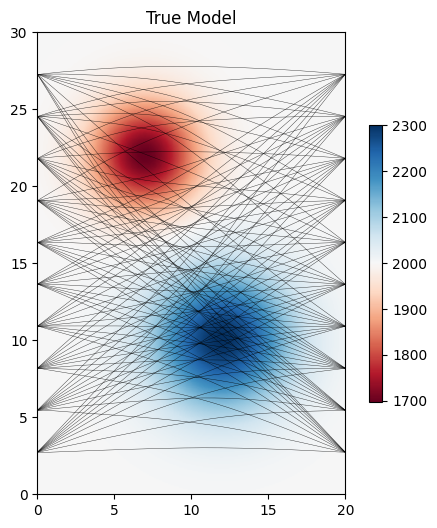

In [167]:
fmm = espresso.FmmTomography()

# Get sources, receivers, and observed data
sources = fmm.sources
receivers = fmm.receivers
obstimes = fmm.data

# Plot true model with paths
smodel_good = fmm.good_model.reshape(fmm.model_shape)
vmodel_good = 1./smodel_good

# xmin, xmax, zmin, zmax = fmm.extent
# pad_x = 0.05 * (xmax - xmin)
# pad_z = 0.05 * (zmax - zmin)

# extent_padded = (
#     xmin - pad_x,
#     xmax + pad_x,
#     zmin - pad_z,
#     zmax + pad_z,
# )
extent_padded = fmm.extent # i changed this, which is what malcolm has used in his notebook; earlier the commented lines were being used.;
# extent_padded is an argument to forward_func

options = wt.WaveTrackerOptions(paths=True)
result = wt.calc_wavefronts(vmodel_good, receivers, sources, extent=extent_padded, options=options)
paths = result.paths

wt.display_model(vmodel_good, paths=paths, extent=extent_padded, line=0.3, alpha=0.82, title='True Model')

In [168]:
pprint.pprint(fmm.metadata)

{'author_names': ['Nick Rawlinson', 'Malcolm Sambridge'],
 'citations': [('Rawlinson, N., de Kool, M. and Sambridge, M., 2006. Seismic '
                'wavefront tracking in 3-D heterogeneous media: applications '
                'with multiple data classes, Explor. Geophys., 37, 322-330.',
                ''),
               ('Rawlinson, N. and Urvoy, M., 2006. Simultaneous inversion of '
                'active and passive source datasets for 3-D seismic structure '
                'with application to Tasmania, Geophys. Res. Lett., 33 L24313',
                '10.1029/2006GL028105'),
               ('de Kool, M., Rawlinson, N. and Sambridge, M. 2006. A '
                'practical grid based method for tracking multiple refraction '
                'and reflection phases in 3D heterogeneous media, Geophys. J. '
                'Int., 167, 253-270',
                ''),
               ('Saygin, E. 2007. Seismic receiver and noise correlation based '
                'studies in Aust

## 1. Define the problem

In [169]:
# get problem information from espresso FmmTomography
model_size = fmm.model_size         # number of model parameters
model_shape = fmm.model_shape       # 2D spatial grids
data_size = fmm.data_size           # number of data points
ref_start_slowness = fmm.starting_model

print(f"Model size: {model_size}")
print(f"Data size (N): {data_size}")

Model size: 1536
Data size (N): 100


In [170]:
# add regularization: damping + smoothing
# Same regularization as original notebook
damping_factor = 500
smoothing_factor = 5e4
reg_damping = damping_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape, 
    weighting_matrix="damping", 
    reference_model=ref_start_slowness
)
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
reg = reg_damping + reg_smoothing

---
## 2. Reduced Likelihood Setup using ReducedLikelihoodManager

We use `ReducedLikelihoodManager` from `cofi.utils` to handle the reduced likelihood computation.

In [171]:
# Define the forward function wrapper using pyfm2d
def forward_func(slowness):
    """Forward function returning predicted travel times."""
    options = wt.WaveTrackerOptions()
    result = wt.calc_wavefronts(
        1./slowness.reshape(model_shape), 
        receivers, sources, 
        extent=extent_padded, 
        options=options
    )
    return result.ttimes
# Define the Jacobian function using pyfm2d
def jacobian_fn(model, n_data, fwd_func, fwd_kwargs):
    """Compute the Jacobian matrix for the forward model."""
    options = wt.WaveTrackerOptions(paths=True, frechet=True)
    result = wt.calc_wavefronts(
        1./model.reshape(model_shape), 
        receivers, sources, 
        extent=extent_padded, 
        options=options
    )
    return result.frechet.toarray()

### Case 1: Scaled Covariance ($C_d = \nu \cdot C_d^{\text{ref}}$)

We use identity matrix as the reference covariance. The algorithm will estimate $\nu$.

In [172]:
# Reference covariance matrix (identity in this example)
Cd_ref = np.eye(data_size)*0.000002**2

# Create ReducedLikelihoodManager with 'scaled' case
rl_manager_scaled = ReducedLikelihoodManager(
    fwd_funcs=[(forward_func, {})],
    d_obs_list=[obstimes],
    jacobian_fn=jacobian_fn,
    cases='scaled',
    Cd_refs=Cd_ref,
    track_stats=True
)

# Check initial values
init_obj_scaled = rl_manager_scaled.objective(ref_start_slowness)
init_reg = reg(ref_start_slowness)
print(f"Initial reduced likelihood objective (scaled): {init_obj_scaled:.4f}")
print(f"Initial regularization: {init_reg:.4f}")

Initial reduced likelihood objective (scaled): 799.0438
Initial regularization: 0.0000


In [173]:
# Define objective, gradient, and hessian using the ReducedLikelihoodManager
def objective_func_scaled(slowness, rl_manager, reg):
    data_misfit = rl_manager.objective(slowness)
    model_reg = reg(slowness)
    return data_misfit + model_reg

def gradient_scaled(slowness, rl_manager, reg):
    data_misfit_grad = rl_manager.gradient(slowness)
    model_reg_grad = reg.gradient(slowness)
    return data_misfit_grad + model_reg_grad

def hessian_scaled(slowness, rl_manager, reg):
    data_misfit_hess = rl_manager.hessian(slowness)
    model_reg_hess = reg.hessian(slowness)
    return data_misfit_hess + model_reg_hess

In [174]:
# Set up the problem for scaled case
fmm_problem_scaled = cofi.BaseProblem()
fmm_problem_scaled.set_initial_model(ref_start_slowness)
fmm_problem_scaled.set_objective(objective_func_scaled, args=[rl_manager_scaled, reg])
fmm_problem_scaled.set_gradient(gradient_scaled, args=[rl_manager_scaled, reg])
fmm_problem_scaled.set_hessian(hessian_scaled, args=[rl_manager_scaled, reg])

In [175]:
fmm_problem_scaled.summary()

Summary for inversion problem: BaseProblem
Model shape: (1536,)
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'gradient', 'hessian', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['hessian_times_vector']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'blobs_dtype', 'bounds', 'constraints']


### Run Inversion (Scaled Case)

In [176]:
n_params = fmm.model_size
lower = np.full(n_params, 5e-7)
upper = np.full(n_params, np.inf)
bounds = list(zip(lower, upper))

my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="L-BFGS-B",                  # robust, gradient-only, can support bounds, circumvents use of Hessian which is problematic 
    #bounds = bounds,
     options={
        "maxiter": 200,                   # tweak as needed
         "disp": True,                    # print SciPy's convergence info
     },
)

In [177]:
inv_scaled = cofi.Inversion(fmm_problem_scaled, my_options)
inv_result_scaled = inv_scaled.run()
inv_result_scaled.summary()

 Note that at least one two-point ray path
 tracked along the boundary of the model.
 This class of path is unlikely to be
 a true path, and it is STRONGLY RECOMMENDED
 that you adjust the dimensions of your grid
 to prevent this from occurring.
 Note that at least one two-point ray path
 tracked along the boundary of the model.
 This class of path is unlikely to be
 a true path, and it is STRONGLY RECOMMENDED
 that you adjust the dimensions of your grid
 to prevent this from occurring.
 Note that at least one two-point ray path
 tracked along the boundary of the model.
 This class of path is unlikely to be
 a true path, and it is STRONGLY RECOMMENDED
 that you adjust the dimensions of your grid
 to prevent this from occurring.
 Note that at least one two-point ray path
 tracked along the boundary of the model.
 This class of path is unlikely to be
 a true path, and it is STRONGLY RECOMMENDED
 that you adjust the dimensions of your grid
 to prevent this from occurring.
 Note that at le

### Compute the estimated $\nu$ (scaling factor)

Using the formula: $\hat{\nu}_{\text{ML}} = \frac{1}{N}\mathbf{r}^T (C_d^{\text{ref}})^{-1} \mathbf{r}$

In [178]:
# Compute residual at the final model
final_model_scaled = inv_result_scaled.model
print(f"Model stats - min: {final_model_scaled.min():.6e}, max: {final_model_scaled.max():.6e}")

predicted_data_scaled = forward_func(final_model_scaled)
residual_scaled = obstimes - predicted_data_scaled

# Compute nu_ML = (1/N) * r^T @ Cd_ref_inv @ r
Cd_ref_inv = np.linalg.inv(Cd_ref)
N = data_size
nu_ML = (1/N) * residual_scaled.T @ Cd_ref_inv @ residual_scaled

print(f"\nNumber of data points (N): {N}")
print(f"Estimated scaling factor (nu_ML): {nu_ML:.6e}")
print(f"\nThe estimated data covariance is: Cd = {nu_ML:.6e} * Cd_ref")

Model stats - min: 4.286768e-04, max: 6.717672e-04

Number of data points (N): 100
Estimated scaling factor (nu_ML): 8.362673e-08

The estimated data covariance is: Cd = 8.362673e-08 * Cd_ref


Velocity stats - min: 1488.61, max: 2332.76


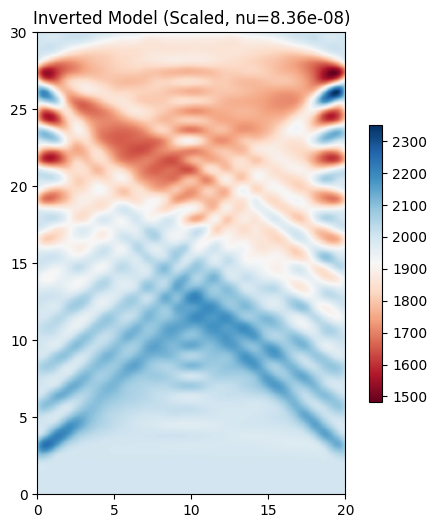

In [179]:
# Plot the result for scaled case
vmodel_scaled = 1./final_model_scaled.reshape(model_shape)
print(f"Velocity stats - min: {vmodel_scaled.min():.2f}, max: {vmodel_scaled.max():.2f}")

wt.display_model(vmodel_scaled, extent=fmm.extent, title=f'Inverted Model (Scaled, nu={nu_ML:.2e})')

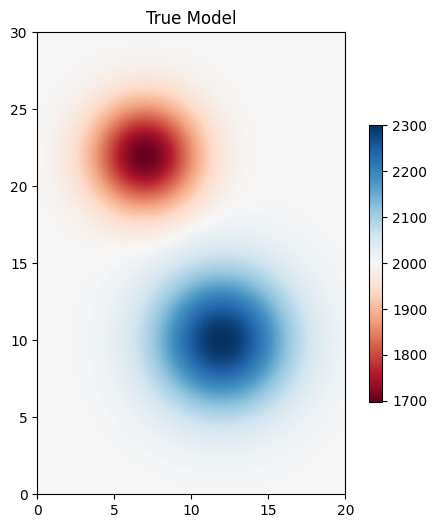

In [180]:
# Plot true model for comparison
wt.display_model(vmodel_good, extent=fmm.extent, title='True Model')

---
### Case 2: Spherical Covariance ($C_d = \sigma^2 I$)

We assume uncorrelated noise with equal variance. The algorithm will estimate $\sigma^2$.

In [181]:
# Create ReducedLikelihoodManager with 'spherical' case
rl_manager_spherical = ReducedLikelihoodManager(
    fwd_funcs=[(forward_func, {})],
    d_obs_list=[obstimes],
    jacobian_fn=jacobian_fn,
    cases='spherical',
    track_stats=True
)

# Check initial value
init_obj_spherical = rl_manager_spherical.objective(ref_start_slowness)
print(f"Initial reduced likelihood objective (spherical): {init_obj_spherical:.4f}")

Initial reduced likelihood objective (spherical): -513.1925


In [182]:
# Define objective, gradient, and hessian using the ReducedLikelihoodManager
def objective_func_spherical(slowness, rl_manager, reg):
    data_misfit = rl_manager.objective(slowness)
    model_reg = reg(slowness)
    return data_misfit + model_reg

def gradient_spherical(slowness, rl_manager, reg):
    data_misfit_grad = rl_manager.gradient(slowness)
    model_reg_grad = reg.gradient(slowness)
    return data_misfit_grad + model_reg_grad

def hessian_spherical(slowness, rl_manager, reg):
    data_misfit_hess = rl_manager.hessian(slowness)
    model_reg_hess = reg.hessian(slowness)
    return data_misfit_hess + model_reg_hess

In [183]:
# Set up the problem for spherical case
fmm_problem_spherical = cofi.BaseProblem()
fmm_problem_spherical.set_initial_model(ref_start_slowness)
fmm_problem_spherical.set_objective(objective_func_spherical, args=[rl_manager_spherical, reg])
fmm_problem_spherical.set_gradient(gradient_spherical, args=[rl_manager_spherical, reg])
fmm_problem_spherical.set_hessian(hessian_spherical, args=[rl_manager_spherical, reg])

In [184]:
fmm_problem_spherical.summary()

Summary for inversion problem: BaseProblem
Model shape: (1536,)
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'gradient', 'hessian', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['hessian_times_vector']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'blobs_dtype', 'bounds', 'constraints']


### Run Inversion (Spherical Case)

In [185]:
inv_spherical = cofi.Inversion(fmm_problem_spherical, my_options)
inv_result_spherical = inv_spherical.run()
inv_result_spherical.summary()

 Note that at least one two-point ray path
 tracked along the boundary of the model.
 This class of path is unlikely to be
 a true path, and it is STRONGLY RECOMMENDED
 that you adjust the dimensions of your grid
 to prevent this from occurring.
 Note that at least one two-point ray path
 tracked along the boundary of the model.
 This class of path is unlikely to be
 a true path, and it is STRONGLY RECOMMENDED
 that you adjust the dimensions of your grid
 to prevent this from occurring.
 Note that at least one two-point ray path
 tracked along the boundary of the model.
 This class of path is unlikely to be
 a true path, and it is STRONGLY RECOMMENDED
 that you adjust the dimensions of your grid
 to prevent this from occurring.
 Note that at least one two-point ray path
 tracked along the boundary of the model.
 This class of path is unlikely to be
 a true path, and it is STRONGLY RECOMMENDED
 that you adjust the dimensions of your grid
 to prevent this from occurring.
 Note that at le

### Compute the estimated $\sigma^2$ (variance)

Using the formula: $\hat{\sigma}^2_{\text{ML}} = \frac{1}{N}\|\mathbf{r}\|^2$

In [186]:
# Compute residual at the final model
final_model_spherical = inv_result_spherical.model
print(f"Model stats - min: {final_model_spherical.min():.6e}, max: {final_model_spherical.max():.6e}")

predicted_data_spherical = forward_func(final_model_spherical)
residual_spherical = obstimes - predicted_data_spherical

# Compute sigma^2_ML = (1/N) * ||r||^2
N = data_size
sigma2_ML = (1/N) * np.dot(residual_spherical, residual_spherical)
sigma_ML = np.sqrt(sigma2_ML)

print(f"\nNumber of data points (N): {N}")
print(f"Estimated variance (sigma^2_ML): {sigma2_ML:.6e}")
print(f"Estimated standard deviation (sigma_ML): {sigma_ML:.6e}")
print(f"\nThe estimated data covariance is: Cd = {sigma2_ML:.6e} * I")

Model stats - min: 4.286768e-04, max: 6.717672e-04

Number of data points (N): 100
Estimated variance (sigma^2_ML): 3.345069e-19
Estimated standard deviation (sigma_ML): 5.783657e-10

The estimated data covariance is: Cd = 3.345069e-19 * I


Velocity stats - min: 1488.61, max: 2332.76


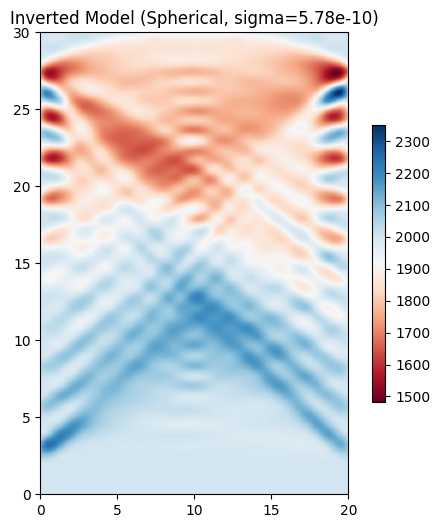

In [187]:
# Plot the result for spherical case
vmodel_spherical = 1./final_model_spherical.reshape(model_shape)
print(f"Velocity stats - min: {vmodel_spherical.min():.2f}, max: {vmodel_spherical.max():.2f}")

wt.display_model(vmodel_spherical, extent=fmm.extent, title=f'Inverted Model (Spherical, sigma={sigma_ML:.2e})')

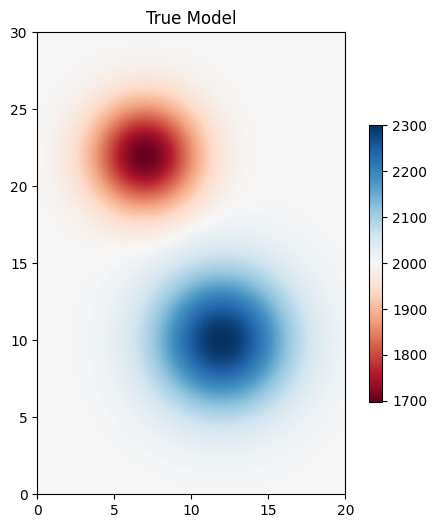

In [188]:
# Plot true model for comparison
wt.display_model(vmodel_good, extent=fmm.extent, title='True Model')

---
## 3. Summary

In [189]:
print("=" * 60)
print("SUMMARY OF REDUCED LIKELIHOOD RESULTS")
print("=" * 60)

print(f"\n--- Scaled Covariance Case (Cd = nu * Cd_ref) ---")
print(f"  Estimated nu: {nu_ML:.6e}")
print(f"  Final objective: {inv_result_scaled.fun:.4f}")
print(f"  RMS residual: {np.sqrt(np.mean(residual_scaled**2)):.6e}")

print(f"\n--- Spherical Covariance Case (Cd = sigma^2 * I) ---")
print(f"  Estimated sigma^2: {sigma2_ML:.6e}")
print(f"  Estimated sigma: {sigma_ML:.6e}")
print(f"  Final objective: {inv_result_spherical.fun:.4f}")
print(f"  RMS residual: {np.sqrt(np.mean(residual_spherical**2)):.6e}")

print(f"\n--- Note ---")
print(f"  For Cd_ref = I, the scaled case should give nu ≈ sigma^2")
print(f"  nu / sigma^2 = {nu_ML / sigma2_ML:.4f}")

print("\n" + "=" * 60)

SUMMARY OF REDUCED LIKELIHOOD RESULTS

--- Scaled Covariance Case (Cd = nu * Cd_ref) ---
  Estimated nu: 8.362673e-08
  Final objective: 731.6196
  RMS residual: 5.783657e-10

--- Spherical Covariance Case (Cd = sigma^2 * I) ---
  Estimated sigma^2: 3.345069e-19
  Estimated sigma: 5.783657e-10
  Final objective: -580.6167
  RMS residual: 5.783657e-10

--- Note ---
  For Cd_ref = I, the scaled case should give nu ≈ sigma^2
  nu / sigma^2 = 250000000000.0000



## Key Observations

1. **ReducedLikelihoodManager** provides a convenient interface for reduced likelihood computations.

2. **Scaled Case**: Estimates the overall noise level while preserving the assumed correlation structure in $C_d^{\text{ref}}$.

3. **Spherical Case**: Assumes uncorrelated noise and estimates a single variance parameter.

4. **Equivalence**: For $C_d^{\text{ref}} = I$, the scaled case reduces to the spherical case, and $\nu = \sigma^2$.

5. **Advantage**: Neither case requires specifying the noise level a priori - it is estimated from the data itself.

---
## Watermark

In [190]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10+31.gd8a24f3.dirty
espresso 0.4.0
numpy 2.2.6
matplotlib 3.10.7
